# Transfer Learning


---

### Importing libraries

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

#### Checking if CUDA capable GPU is available for training....  

In [2]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'
else:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'

CUDA is available!  Training on GPU ...


_CudaDeviceProperties(name='GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4096MB, multi_processor_count=6)


## Load and Transform Data



In [3]:
dataset_dir = 'images/'
train_dir = os.path.join(dataset_dir, 'train/')
test_dir = os.path.join(dataset_dir, 'test/')
valid_dir = os.path.join(dataset_dir, 'test/')

classes = ['Emergency', 'Non Emergency']
print("Classes: ",classes)
print("Total no. of classes = ",len(classes))

Classes:  ['Emergency', 'Non Emergency']
Total no. of classes =  2


### Transforming the Data


### Data-Transformation

In [4]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
valid_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset = datasets.ImageFolder(train_dir,transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir ,transform=test_transforms)
valid_dataset = datasets.ImageFolder(valid_dir,transform=valid_transforms)



print('Training  images: ', len(train_dataset))
print('Testing   images: ', len(test_dataset))
print('Validation images:', len(valid_dataset))

Training  images:  6584
Testing   images:  698
Validation images: 698


### DataLoaders

In [5]:
batch_size = 64
num_workers=0

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset , batch_size=batch_size, num_workers=num_workers, shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = False)

In [6]:
print('Number of  training  batches:', len(train_dataloader))
print('Number of  testing   batches:', len(test_dataloader))
print('Number of validation batches:', len(valid_dataloader))

Number of  training  batches: 103
Number of  testing   batches: 11
Number of validation batches: 11


#### The below code-cell is only for visualization purpose. Have nothing to do with training and testing of model

In [7]:
visual_transforms  = transforms.Compose([
                                       transforms.ToTensor()])
visual_dataset  = datasets.ImageFolder(train_dir ,transform=visual_transforms)
visualization_dataloader=torch.utils.data.DataLoader(visual_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)

### Data visualization

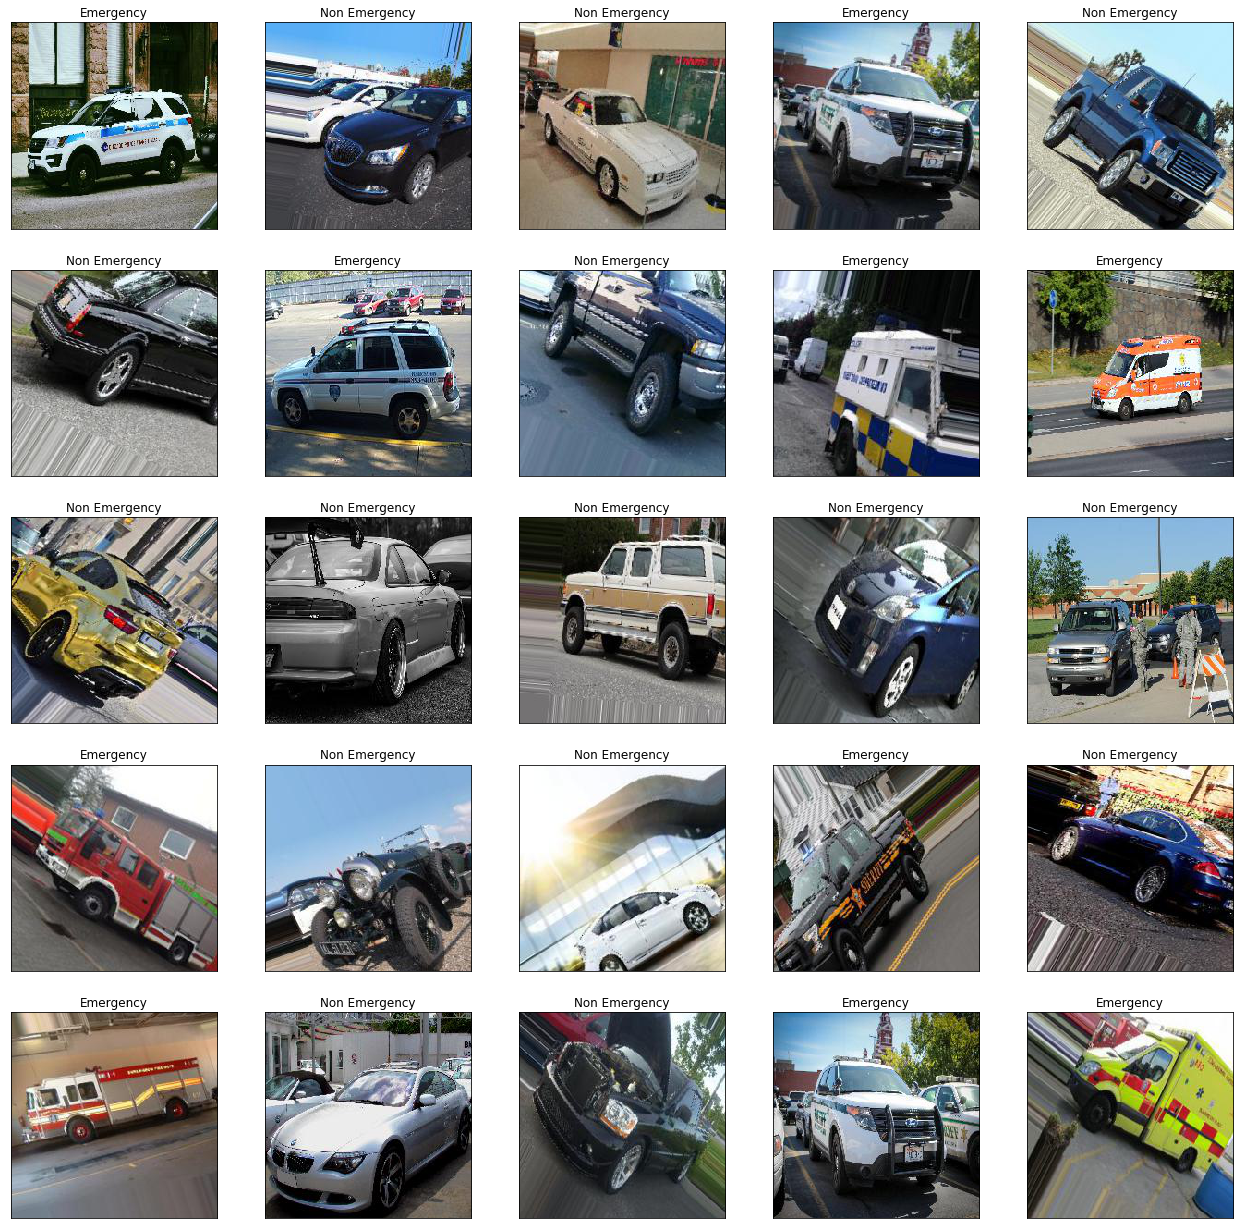

In [8]:
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(22, 22))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

In [9]:
model_name = 'resnet50'

In [10]:
model = models.resnet50(pretrained=True)

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Final layer input and output nodes

In [12]:
print(model.fc.in_features) 
print(model.fc.out_features) 

2048
1000


In [13]:
for param in model.parameters():
    param.requires_grad = False

---
### Final Classifier Layer

In [14]:
import torch.nn as nn

n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs, len(classes)) 
model.fc = last_layer

if train_on_gpu:
    model=model.to(device)

print(model.fc.out_features)

2


In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Loss Function and Optimizer

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

---
# Training




In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
model_filename = 'trained_' + model_name + '.pt'
print('File name for saved model: ',model_filename)

File name for saved model:  trained_resnet50.pt


In [19]:
n_epochs = 30

In [20]:
import time  
a = time.time() 

valid_loss_min = np.Inf 
train_losses,valid_losses, accuracies=[],[],[]

for epoch in range(1, n_epochs+1):
    c = time.time() 
    
    # to keep track of training loss
    training_loss = 0.0
    
    ###################
    # train the model #
    ###################

    for batch_i, (images, labels) in enumerate(train_dataloader):    
        
        if train_on_gpu:
            images = images.to(device)
            labels = labels.to(device)
                    
        optimizer.zero_grad()

        outputs = model.forward(images)
        loss = criterion(outputs, labels)   
        loss.backward()
        optimizer.step()
        training_loss += loss.item()   
        
    ########################
    # validating the model #
    ########################      
    
    
    validation_loss = 0.0
    accuracy = 0.0

    model.eval() 

    with torch.no_grad(): 
        for images, labels in valid_dataloader:   
            
            if train_on_gpu: 
                images = images.to(device)
                labels = labels.to(device)

            outputs = model.forward(images)
            batch_loss = criterion(outputs, labels)
            validation_loss += batch_loss.item()
            

            ps = torch.exp(outputs)   

     
            top_p, top_class = ps.topk(1, dim=1) 

           
            equals = top_class == labels.view(*top_class.shape)   
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()  
                                               
    
    
    train_losses.append(training_loss/len(train_dataloader))    
    valid_losses.append(validation_loss/len(valid_dataloader))
    accuracies.append(((accuracy/len(valid_dataloader))*100.0))
    d = time.time() 
    print(f"Epoch {epoch} "
          f"Time: {int((d-c)/60)} min {int(d-c)%60} sec "
          f"Train loss: {training_loss/len(train_dataloader):.3f}.. "
          f"Validation loss: {validation_loss/len(valid_dataloader):.3f}.. "
          f"Validation accuracy: {((accuracy/len(valid_dataloader))*100.0):.3f}% "
          )
    
    training_loss = 0.0
    
    
    if ( validation_loss/len(valid_dataloader) <= valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min , validation_loss/len(valid_dataloader)))
        torch.save(model.state_dict(), model_filename)
        valid_loss_min = validation_loss/len(valid_dataloader)   
    
    
    model.train()
          

            
b = time.time()  
print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")

Epoch 1 Time: 1 min 30 sec Train loss: 0.368.. Validation loss: 0.227.. Validation accuracy: 90.904% 
Validation loss decreased (inf --> 0.226704).  Saving model ...
Epoch 2 Time: 1 min 3 sec Train loss: 0.259.. Validation loss: 0.194.. Validation accuracy: 91.928% 
Validation loss decreased (0.226704 --> 0.193869).  Saving model ...
Epoch 3 Time: 1 min 4 sec Train loss: 0.226.. Validation loss: 0.192.. Validation accuracy: 92.099% 
Validation loss decreased (0.193869 --> 0.192311).  Saving model ...
Epoch 4 Time: 1 min 4 sec Train loss: 0.223.. Validation loss: 0.202.. Validation accuracy: 92.908% 
Epoch 5 Time: 1 min 4 sec Train loss: 0.220.. Validation loss: 0.168.. Validation accuracy: 93.221% 
Validation loss decreased (0.192311 --> 0.167721).  Saving model ...
Epoch 6 Time: 1 min 5 sec Train loss: 0.213.. Validation loss: 0.166.. Validation accuracy: 93.079% 
Validation loss decreased (0.167721 --> 0.165968).  Saving model ...
Epoch 7 Time: 1 min 6 sec Train loss: 0.199.. Validat

### Load the Model with the Lowest Validation Loss

In [21]:
model.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

---
## Testing

In [24]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes_accuracies=[]
model.eval() 
counter = 0


for images, labels in test_dataloader: 
    

    if train_on_gpu:
        images = images.to(device)
        labels = labels.to(device)
    
   
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    ps, pred = torch.max(output, 1)    
    
  
    for i in range(len(images)):
        class_total[labels[i]] += 1
        if pred[i] == labels[i]:
            class_correct[pred[i]] += 1
    counter += 1
    

test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    classes_accuracies.append(100 * class_correct[i] / class_total[i])
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
                          (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.153738

Test Accuracy of Emergency: 92% (275/297)
Test Accuracy of Non Emergency: 93% (376/401)

Test Accuracy (Overall): 93% (651/698)


## Saving the best model along with `Training Loss`, `Validations Loss`, `Accuracy`, `Class Accuracy`

In [25]:
checkpoint = {'training_losses': train_losses,
              'valid_losses': valid_losses,
              'accuracies': accuracies,
              'classes_accuracies':classes_accuracies,
              'state_dict': model.state_dict()}

torch.save(checkpoint, model_filename)

### Visualize Sample Test Results

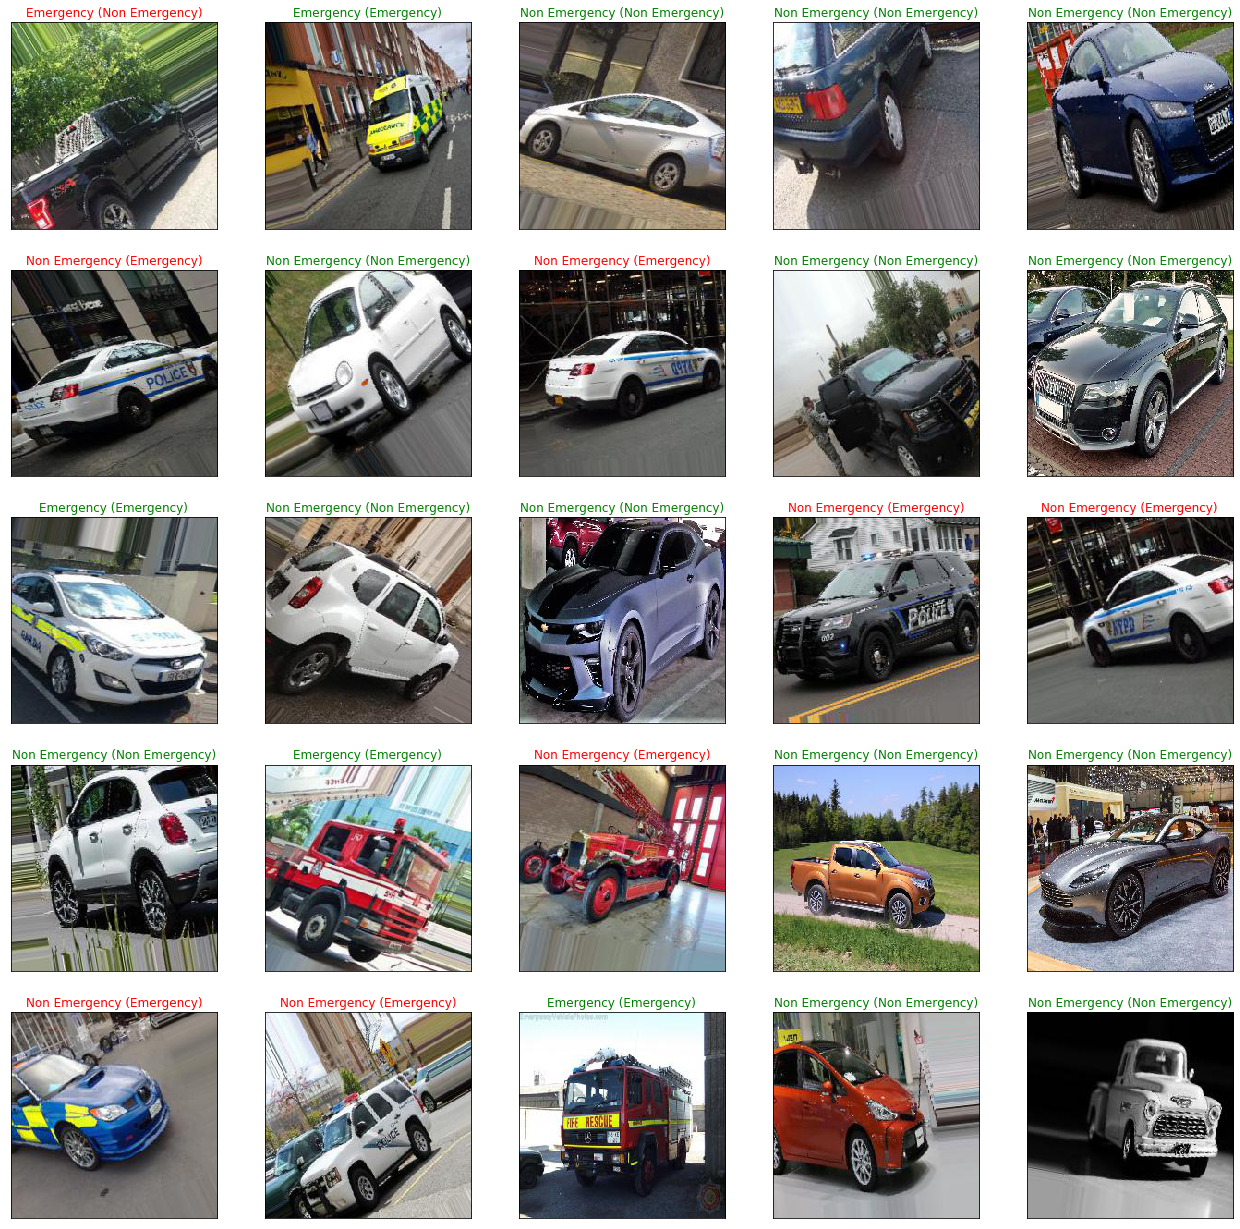

In [27]:
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:    
    images = images.to(device)
    
output = model(images)
images = images.cpu()
output_ps, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(22, 22))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
#Format -> prediction(label)